In [1]:
import pytest
pytest.importorskip('pycuda')

<module 'pycuda' from '/home/markus/miniconda3/envs/pystencils/lib/python3.8/site-packages/pycuda/__init__.py'>

In [2]:
from lbmpy.session import *

# Tutorial 01: Running pre-defined scenarios


*lbmpy* is a module to do Lattice Boltzmann simulations in Python. 

In this tutorial you will get a broad overview of *lbmpy*'s features. We will run some of the included scenarios that come with *lbmpy*, like a channel flow and a lid driven cavity. This tutorial uses the simple, high-level API of *lbmpy*, while the following tutorials go into the low-level details.

The only prerequisite for this tutorial is basic Python and [numpy](http://www.numpy.org/) knowledge.


> #### What's special about *lbmpy* ?
> The LBM kernels (i.e. the functions that do all the computations) are not written in Python. Instead *lbmpy* generates optimized C or CUDA code for these kernels and compiles it using the *pystencils* module. In that way we get very fast LBM kernels, a lot faster than pure Python implementations and probably also faster than handwritten C kernels. This sounds complicated, but we don't have to care about all this background work, since all compiled kernels are available as Python functions again. Thus *lbmpy* can be used just like any other Python package.


## Lid Driven Cavity

We start by simulating a fluid in a rectangular box, where one wall (the lid) is moving. This is called a 'lid driven cavity'. At the stationary walls *no-slip* boundary conditions are set, which enforce zero velocity at the wall. At the lid there is a *velocity bounce back (UBB)* boundary condition, which sets zero normal velocity and a prescribed tangential velocity.

We don't have to set up all these boundary conditions manually since there is a function ``create_lid_driven_cavity``  that does all the work for us. This function takes the tangential velocity of the lid, which drives the flow. It is given in lattice units and to get a stable simulation it should be smaller than 0.1. The `relaxation_rate` determines the viscosity of the fluid: Small relaxation rates correspond to high viscosity. The `relaxation_rate` has to be between 0 and 2.

In [3]:
ldc_scenario = create_lid_driven_cavity(domain_size=(80,50), lid_velocity=0.01, relaxation_rate=1.95)
ldc_scenario.method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$1.95$
$x$,$u_{0}$,$1.95$
$y$,$u_{1}$,$1.95$
$x^{2}$,$\frac{\rho}{3} + u_{0}^{2}$,$1.95$
$y^{2}$,$\frac{\rho}{3} + u_{1}^{2}$,$1.95$
$x y$,$u_{0} u_{1}$,$1.95$
$x^{2} y$,$\frac{u_{1}}{3}$,$1.95$
$x y^{2}$,$\frac{u_{0}}{3}$,$1.95$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$1.95$


The *run* method of the scenario runs the specified amount of time steps. When you run the next cell, 2000 time steps are executed and the velocity field is plotted. You can run the cell multiple times to see a time evolution. 

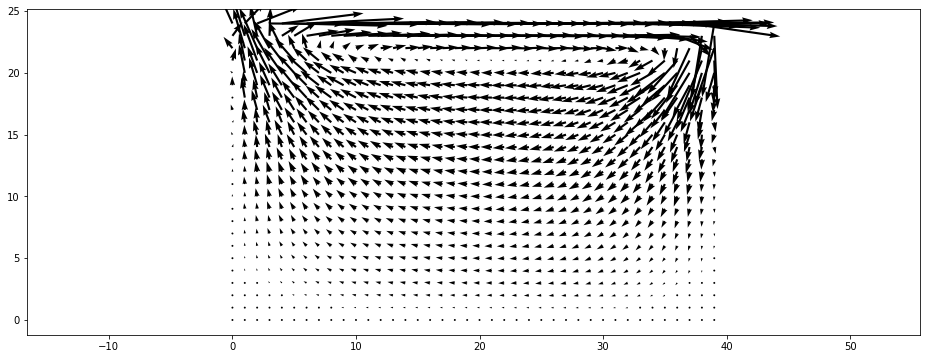

In [4]:
ldc_scenario.run(2000)
plt.vector_field(ldc_scenario.velocity_slice(), step=2);

### Variations to experiment with:
- simulate with a higher ``relaxation_rate`` (i.e. higher [Reynolds number](https://en.wikipedia.org/wiki/Reynolds_number)), keep in mind that the ``relaxation_rate`` has to be smaller than 2. You might have to increase (``domain_size``) to keep the simulation stable and run more time steps to get to the stationary solution. You also might want to increase the ``step`` parameter for the plot, to reduce the number of arrows.
- run a 3D simulation by adding a third dimension size to ``domain_size``. The ``velocity`` property of the scenario is now a 3D field that has to be sliced before it can be plotted, e.g. ``ldc_scenario.velocity[:, :, 10, 0:2]`` generates a slice at ``z=10`` and plot the ``x`` and ``y`` component of the velocity.

##  Fully periodic flow

Another simple scenario is a box with periodic boundary conditions in all directions. We initialize a non-zero initial velocity field, which is decaying over time due to viscous effects and the absence of driving forces or boundary conditions. In this example we initialize a shear flow where in one stripe the fluid is moving to the left, and everywhere else to the right. We perturbe this initial velocity field with random noise to get an instable shear layer.   

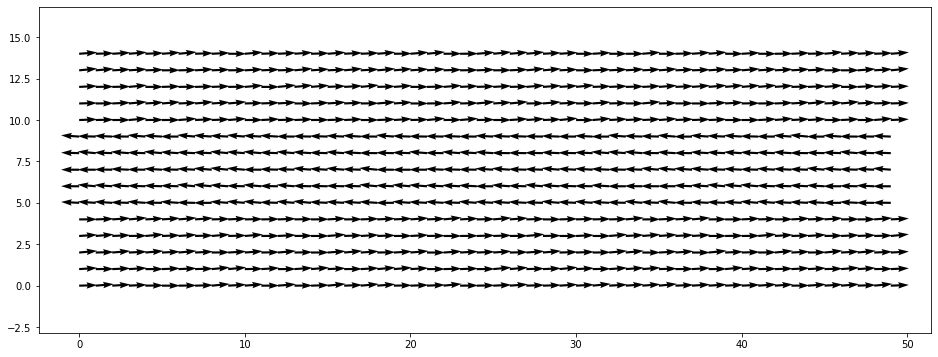

In [5]:
width, height = 200, 60
velocity_magnitude = 0.05
init_vel = np.zeros((width,height,2))
# fluid moving to the right everywhere...
init_vel[:, :, 0] = velocity_magnitude  
 # ...except at a stripe in the middle, where it moves left
init_vel[:, height//3 : height//3*2, 0] = -velocity_magnitude
# small random y velocity component
init_vel[:, :, 1] = 0.1 * velocity_magnitude * np.random.rand(width,height)

plt.vector_field(init_vel, step=4);

With this initial velocity field we create a simulation scenario:

In [6]:
shear_flow_scenario = create_fully_periodic_flow(initial_velocity=init_vel, relaxation_rate=1.97)

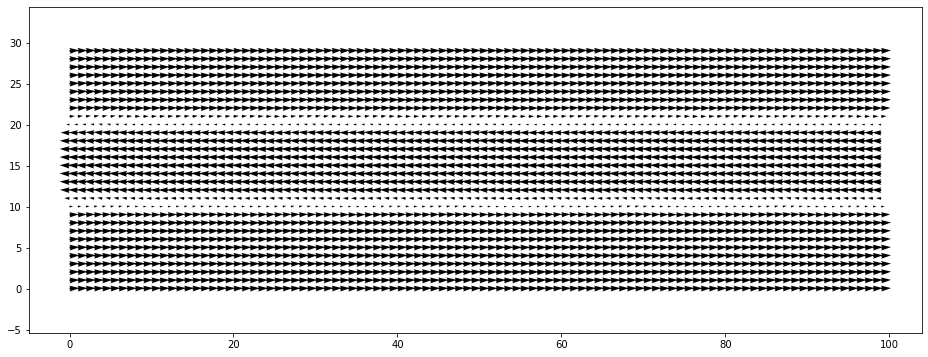

In [7]:
shear_flow_scenario.run(500)
plt.vector_field(shear_flow_scenario.velocity[:, :])

Instead of plotting a single point in time we create an animation. For this we first have to 
define an update function that runs a few time steps and returns the field to plot.
This function is called ``iterations`` times, then the animation stops. 
To cancel the animation while it is running, hit the stop button in the IPython menu bar.

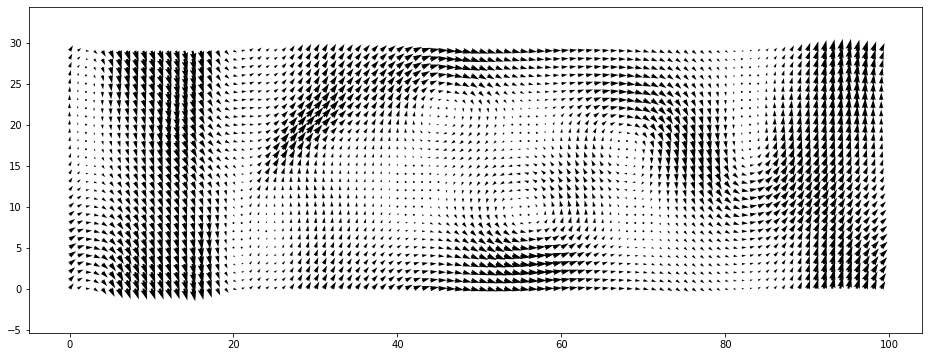

In [8]:
def next_frame():
    shear_flow_scenario.run(50)
    return shear_flow_scenario.velocity[:, :]
display_animation(plt.vector_field_animation(next_frame, step=2), iterations=50)

Vortices are created between the two layers. This phenomenon is called [Kelvin-Helmholz Instability](https://en.wikipedia.org/wiki/Kelvin%E2%80%93Helmholtz_instability). For a better visualization of the vortices we can plot the [vorticity](https://en.wikipedia.org/wiki/Vorticity) of velocity field:

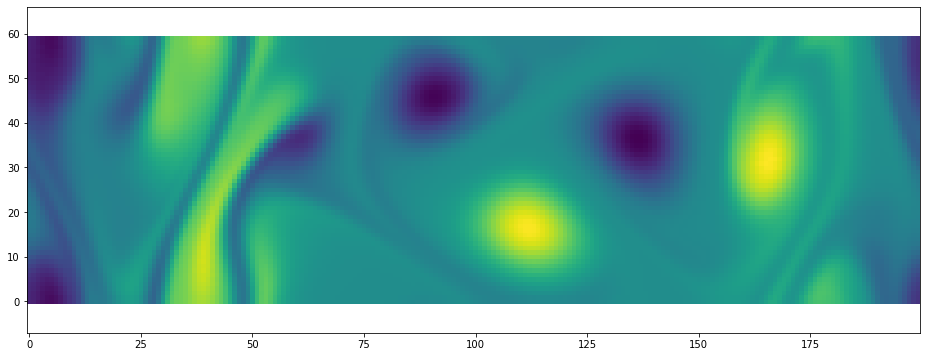

In [9]:
plt.scalar_field(vorticity_2d(shear_flow_scenario.velocity[:, :]));

###  Variations to experiment with:
- make an animation of the vorticity
- increase the ``relaxation_rate``. What is the maximum relaxation rate you can get before the simulation gets unstable?
- use an entropic method to get to higher relaxation rates:

```
entropic_shear_flow_scenario = create_fully_periodic_flow(initial_velocity=init_vel, method='trt-kbc-n4',  
                                                          entropic=True, compressible=True)
entropic_shear_flow_scenario.kernel_params['omega_0'] = 1.999
```

## Channel

In the last part of this tutorial you learn how to modify the boundary handling of scenarios.
Therefor we set up a channel flow and place some objects into it.

The channel will be driven by a constant body force e.g. gravity which acts in x direction. Along the flow direction periodic boundary conditions are used whereas the walls are modeled with a *noslip* boundary condition.

In [10]:
channel_scenario = create_channel(domain_size=(300,100), force=1e-7, initial_velocity=(0.025,0),
                                  relaxation_rate=1.97, optimization={'target': 'gpu'})

As in the last scenario, we specify an initial velocity here. Instead of passing a velocity value for every cell we specify here a constant for the complete domain.

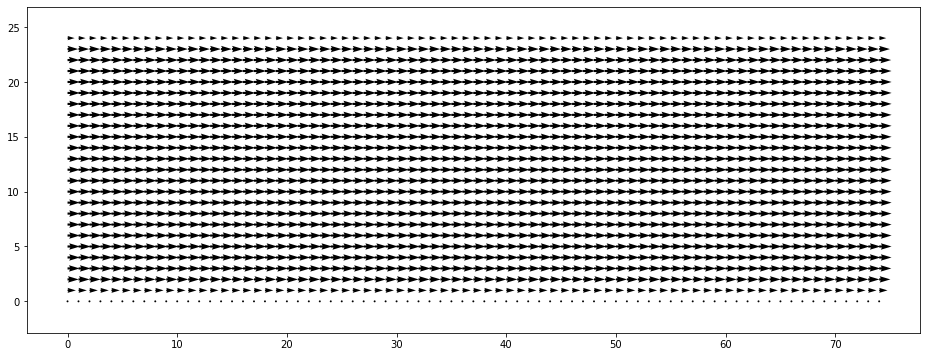

In [11]:
channel_scenario.run(10000)
plt.vector_field(channel_scenario.velocity[:, :], step=4);

This is a 2D [Poiseuille flow](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation) where a parabolic profile of the x velocity is expected for the stationary case.

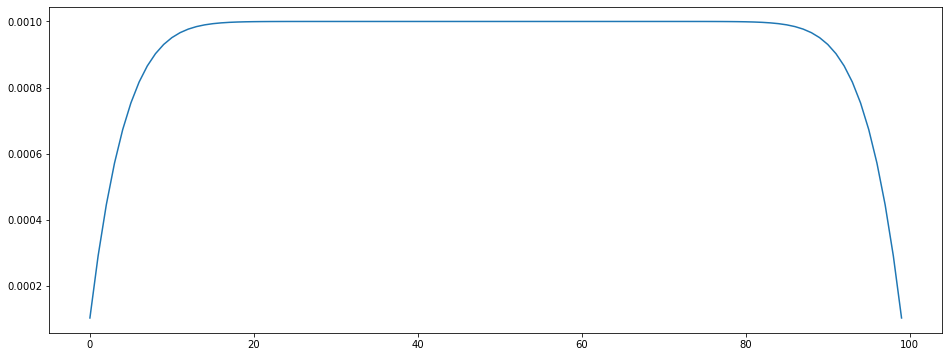

In [12]:
vel_profile = channel_scenario.velocity[0.5, :, 0]
plt.plot(vel_profile);

The stationary state is not yet reached, you can run more time steps and see how the profile gets closer to a parabola.


### Modifying boundaries

Lets first view the current boundary configuration:


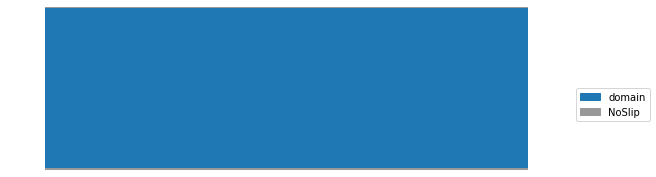

In [13]:
def draw_boundary_setup():
    fig = plt.figure(figsize=(10.0, 3.0))
    plt.boundary_handling(channel_scenario.boundary_handling)
    plt.axis('off');

draw_boundary_setup()

In above plot you can see that the *no-slip* boundaries at the top and bottom of the channel, otherwise the channel is empty.

Since an empty channel is pretty boring, lets put an obstacle in it. We start with the simplest option: a rectangular, solid block. The rectangle is specified as a slice, similar to advanced *numpy* indexing. The ``make_slice`` function can also take ``float`` as indices for specifying the slice relative to the domain size. The following cell puts an obstacle into the domain that has one third of the channel height.
Additionally we have to pass a function that defines what should happen at the boundary (here ``noSlip``).
By default, the name of the function is also the boundary name.

In [14]:
from lbmpy.boundaries import NoSlip

wall = NoSlip()
channel_scenario.boundary_handling.set_boundary(wall, make_slice[0.2:0.25, 0:0.333])

2

When plotting the boundary handling again, we see the rectangular obstacle:

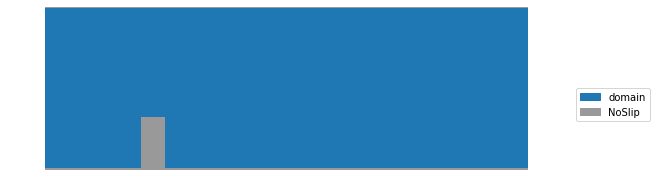

In [15]:
draw_boundary_setup()

When setting and plotting boundaries the domain is actually 2 cells larger than originally specified. These so called 'ghost layer' slices are one cell thick and are automatically added at each domain boundary. They can be used to set boundaries and are also used for communication when running distributed memory parallel simulations.
When specifying the slice, keep in mind that the domain is actually slightly larger. When plotting the simulation results the ghost layers are automatically removed.

To convert a cell back to ``domain``, the same method can be used. To demonstrate this, we cut a piece out of the obstacle:

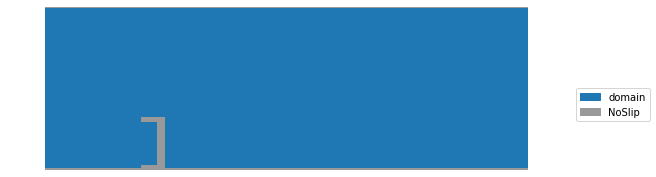

In [16]:
channel_scenario.boundary_handling.set_boundary('domain', make_slice[0.2:0.235, 0.0333:0.3])
fig = plt.figure(figsize=(10.0, 3.0))
plt.boundary_handling(channel_scenario.boundary_handling)
plt.axis('off');

To add non-rectangular obstacles one can also pass a mask array, which is ``True`` for cells where the boundary should be set. This is demonstrated in the next cell, where a sphere is placed in the channel.

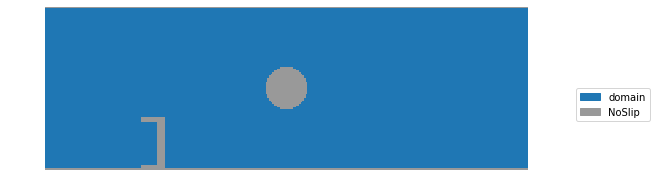

In [17]:
def set_sphere(x, y):
    shape = channel_scenario.domain_size
    mid = (0.5 * shape[0], 0.5 * shape[1])
    radius = 13
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

channel_scenario.boundary_handling.set_boundary(wall, mask_callback=set_sphere)
draw_boundary_setup()

Now, we run the simulation to see the flow aroung the obstacles:

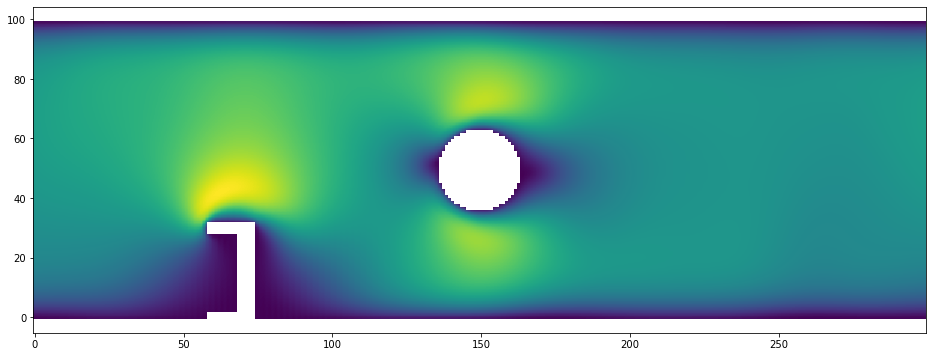

In [18]:
channel_scenario.run(10000)
plt.vector_field_magnitude(channel_scenario.velocity[:,:]);

###  Variations to experiment with:

- increase the Reynolds number. You might also have to increase the resolution, and/or use a more advanced method like cumulant or entropic stabilization
